In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

In [2]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [12]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(3, 1)] * 12, weight_final_time = 30, weight_job_deadline = 50, weight_op_rate = 20)

Goal reached! final score= 65.23565694084628
finish_time 4000
machine_operation_rate [0.35, 0.9, 0.8, 0.625, 0.7, 0.6, 0.65, 0.7]
job_deadline [900, 1300, 1800, 2500, 900, 1250, 1050, 1600, 1050, 1500, 2200, 900, 900, 1200, 1050, 1400, 2000, 2700, 1500, 2200, 3000, 4000, 750, 1100, 900, 1400, 2000, 1050, 1600, 2300, 1050]
job_time_exceeded [900, 2300, 1000, 800, 2600, 2450, 1150, 800, 1450, 1400, 1800, 500, 1900, 1000, 0, 0, 0, 0, 700, 300, 100, 0, 0, 200, 800, 100, 1200, 50, 400, 500, 850]
current_repeats [4, 2, 2, 3, 1, 2, 4, 4, 2, 3, 3, 1]
3150.0


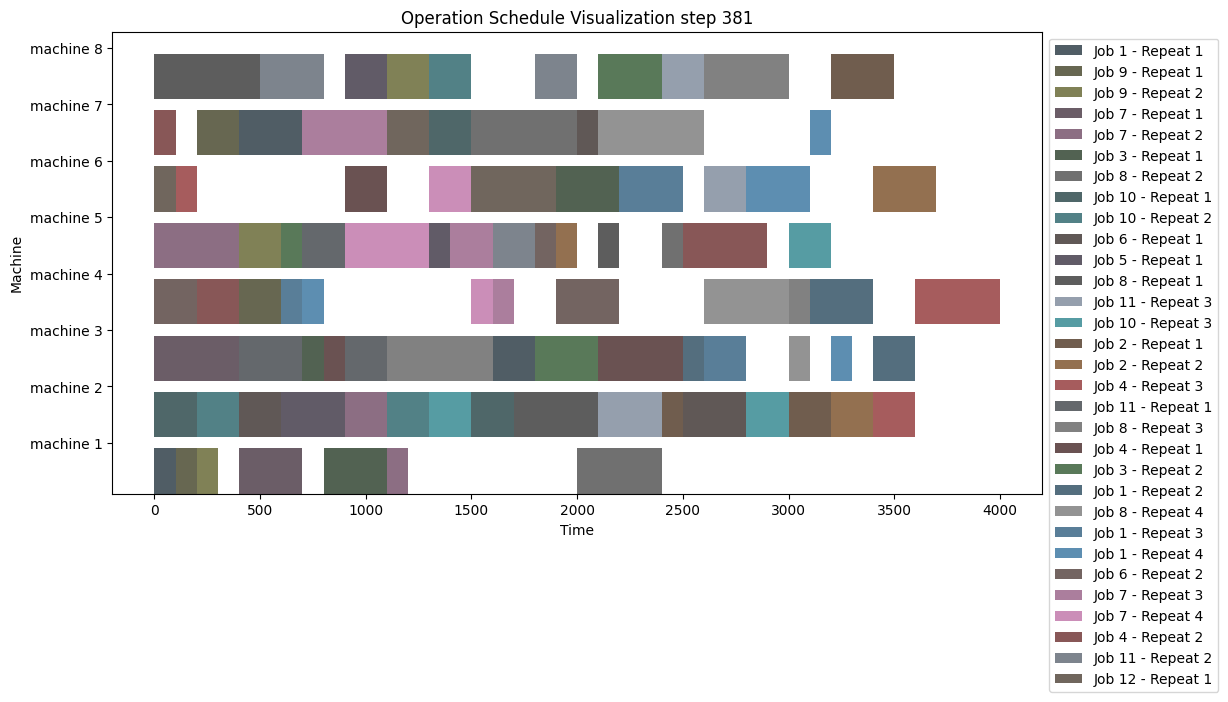

In [11]:
step = 0
obs, info = env.reset()
#print(info['schedule_buffer'])

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f"action : {action // 3}, {action % 3}")
    # print(info['schedule_buffer'])
    # env.visualize_graph()
    done = terminated or truncated
    
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        print('current_repeats', info['current_repeats'])
        print(env.target_time)
        env.render()
        break

In [10]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, max_repeats):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, max_repeats = max_repeats, test_mode = test_mode)
        return env
    return _init

envs = [make_env(job_paths[0], machine_paths[0], True, [3]*12), make_env(job_paths[0], machine_paths[0], False, [5]*12)]

vec_env = SubprocVecEnv(envs)

In [ ]:
log_path = "./logs/tmp/1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

# Create the evaluation environment
eval_env = DummyVecEnv([make_env(job_paths[0], machine_paths[0], False, [5]*12)])

# Create the EvalCallback
eval_callback = EvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=10000,
                             deterministic=True, render=False)

In [13]:
model = PPO('MultiInputPolicy', env, verbose=1)
model.set_logger(new_logger)
model.learn(1_000_000, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 474      |
|    ep_rew_mean     | -160     |
| time/              |          |
|    fps             | 1143     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 394         |
|    ep_rew_mean          | -118        |
| time/                   |             |
|    fps                  | 950         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012514723 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [18]:
env1 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(3, 1)] * 12, weight_final_time = 30, weight_job_deadline = 50, weight_op_rate = 20)
env2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(3, 1)] * 12, weight_final_time = 30, weight_job_deadline = 50, weight_op_rate = 20, test_mode = True)

custom_env = [env1, env2]

Goal reached! final score= 52.54439400894481
job_deadline [900, 900, 1250, 1050, 1600, 1050, 1500, 900, 1400, 900, 1200, 1050, 1400, 2000, 1500, 750, 1100, 900, 1400, 2000, 1050, 1050, 1500, 2100]
job_time_exceeded [700, 0, 0, 850, 1000, 0, 0, 200, 0, 1000, 1300, 0, 200, 600, 0, 50, 0, 0, 400, 0, 850, 650, 900, 1000]
current_repeats [1, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 3]
1962.5


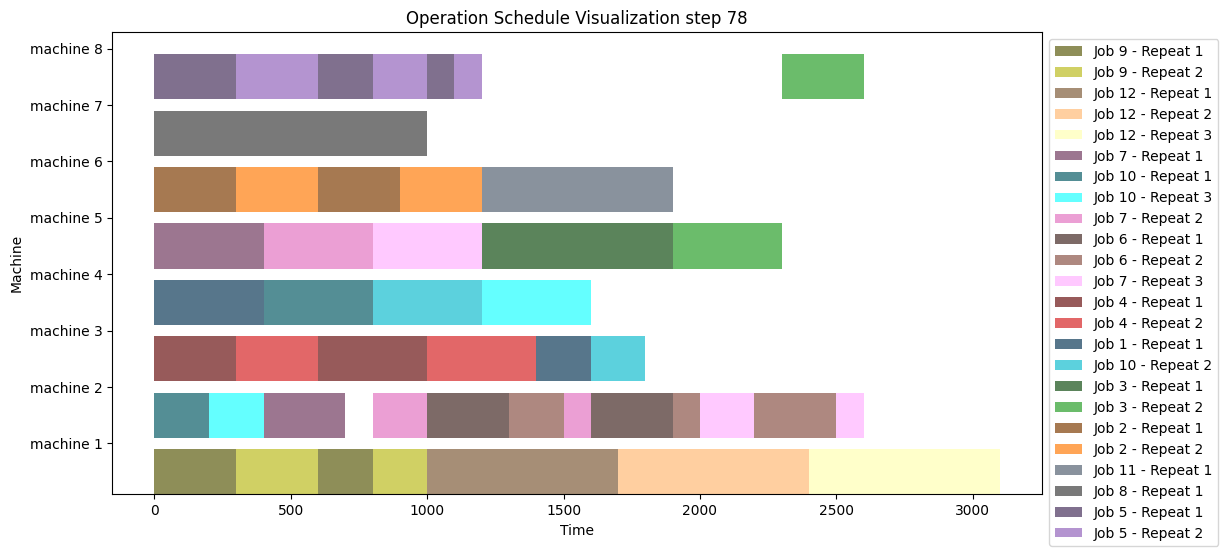

Goal reached! final score= 46.21392332973649
job_deadline [900, 1300, 1800, 900, 1250, 1800, 1050, 1600, 2300, 1050, 1500, 2200, 900, 1400, 2000, 900, 1200, 1700, 1050, 1400, 2000, 1500, 2200, 3000, 750, 1100, 1600, 900, 1400, 2000, 1050, 1600, 2300, 1050, 1500, 2100]
job_time_exceeded [1400, 1200, 900, 0, 250, 0, 1650, 2400, 2000, 0, 200, 0, 700, 300, 0, 900, 2000, 1800, 0, 0, 0, 0, 0, 0, 150, 200, 0, 1600, 1300, 1100, 2350, 2000, 800, 1150, 1400, 400]
current_repeats [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3000.0


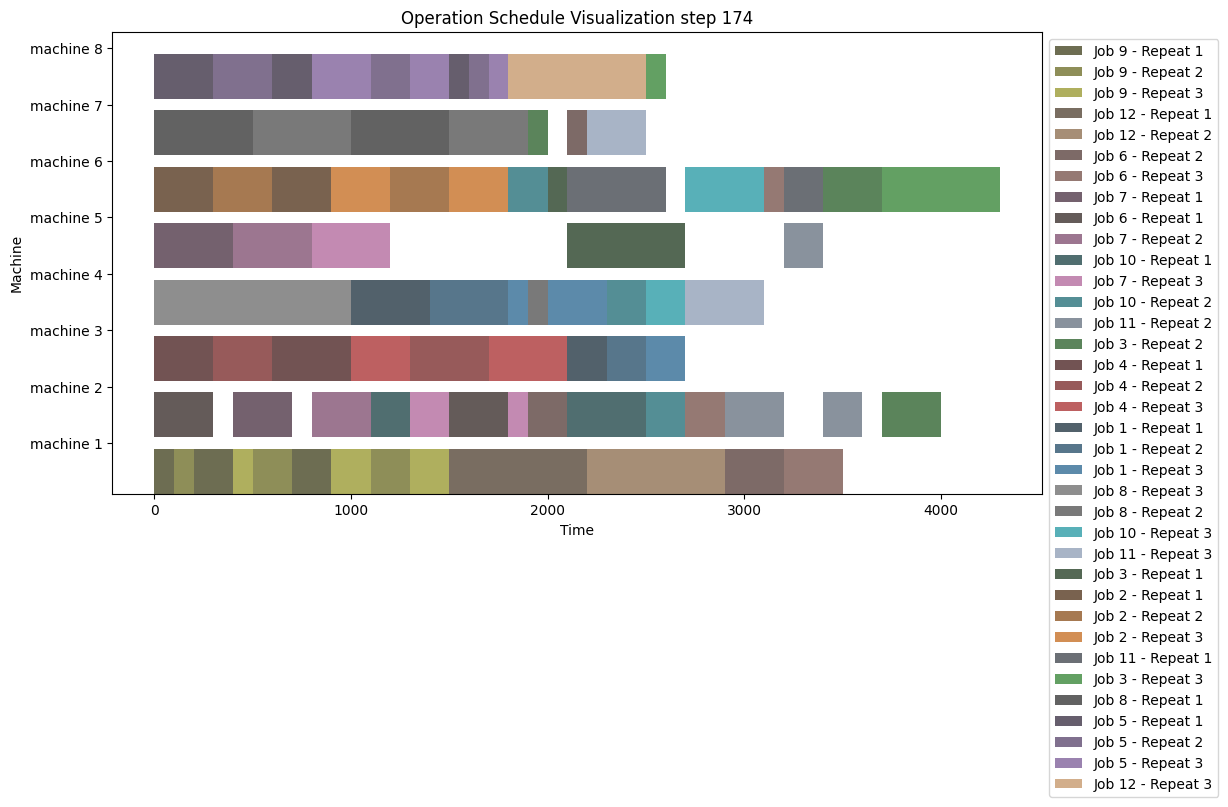

In [19]:
for env in custom_env:
    obs, info = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic = False)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        # print('job_deadline ', info['job_deadline'])
        # print('tardiness ', info['job_estimated_tardiness'])
        # env.render()
        if done:
            print("Goal reached!", "final score=", reward)
            print('job_deadline', info['job_deadline'])
            print('job_time_exceeded', info['job_time_exceeded'])
            print('current_repeats', info['current_repeats'])
            print(env.target_time)
            env.render()
            break

In [2]:
model.save("PPO_random_repeat")

NameError: name 'model' is not defined